# Simple one-way ANOVA 
- 03/16/2022
- RPneg
- TIC normalized dataset

# load library

In [10]:
# Let the middle rows included.
options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)

In [11]:
library(dplyr)
library(car)
library(glue)
source("./utilis/utilis.R") # merge_by_rowName

## Read data table

In [12]:
exp_label = 'hMinImp_TICnorm_groupFil0.3_RPneg'

In [13]:
feat_df = read.csv("../../output/preproc_fultab_lab_targlist_79_rmTn750K/FC_log2_hMinImp_TICn_groupFil0.3_RPneg_blkM_featab.csv", row.names = 1)

In [14]:
head(feat_df)

,gMean_Tn,gMean_CD8stem,gMean_CD8trans,gMean_CD8TD,log2FC_CD8stemvsTn,log2FC_CD8transvsTn,log2FC_CD8TDvsTn,log2FC_CD8transvsCD8stem,log2FC_CD8TDvsCD8stem,log2FC_CD8TDvsCD8trans,CD8TD_750K_1,CD8TD_750K_2,CD8stem_250K_1,CD8stem_300K_2,CD8trans_250K_2,CD8trans_350K_1,Tn_250K_1,Tn_250K_2,pooled_1,pooled_2,pooled_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2,15.40298,20.61094,17.89731,22.07496,5.20796237,2.4943354,6.6719850,-2.71362692,1.4640226,4.17764952,20.71193,23.43799,19.79550,21.42638,14.88169,20.91293,14.88169,15.92426,21.62464,21.63637,21.81846
F4,20.64861,20.74838,21.00853,20.54686,0.09976877,0.3599219,-0.1017482,0.26015310,-0.2015169,-0.46167004,19.43721,21.65651,20.57980,20.91696,20.83635,21.18071,20.32537,20.97185,20.40591,20.90688,21.07221
F5,18.04368,19.67452,18.92858,19.03544,1.63084646,0.8849006,0.9917608,-0.74594587,-0.6390857,0.10686022,18.04368,20.02720,19.41603,19.93301,18.04368,19.81348,18.04368,18.04368,18.97515,19.81825,19.64948
F6,19.50978,20.67609,20.34729,20.32589,1.16631037,0.8375113,0.8161117,-0.32879908,-0.3501987,-0.02139958,19.50978,21.14201,20.33467,21.01752,19.50978,21.18480,19.50978,19.50978,21.02416,21.08150,21.03356
F10,16.76541,16.25004,16.26637,15.68275,-0.51537320,-0.4990412,-1.0826623,0.01633199,-0.5672891,-0.58362107,15.68275,15.68275,16.81733,15.68275,16.84999,15.68275,16.57091,16.95991,17.81606,15.68275,16.73556
F11,18.55330,17.13836,17.01117,15.74327,-1.41493989,-1.5421351,-2.8100320,-0.12719518,-1.3950921,-1.26789697,15.74327,15.74327,18.53345,15.74327,18.27906,15.74327,17.56774,19.53887,18.86895,18.12033,16.73586


#### remove duplicated id

In [15]:
# This will drop all rows where the id_number value is duplicated, and keep only the first occurrence of each unique id_number value.
# feat_df = feat_df[!duplicated(feat_df['id_number']),]

##### Check the data, make sure it is already log2-transformed

In [16]:
data.df.log2 = feat_df[,grep('CD8TD|CD8stem|CD8trans|Tn',colnames(feat_df))]

## Read metadata

In [17]:
meta_df = read.csv("../../../seq/RPneg_addgrp.csv")

In [18]:
rownames(meta_df) = meta_df$Sample_ID_upd
sub_meta_df = meta_df[colnames(data.df.log2),]
meta_df = sub_meta_df

------

# Summary
- check if the metadata & data matched (It should be as they have been filtered in the last notebook)
- check key metadata

In [19]:
nrow(meta_df) == ncol(data.df.log2)

[1] TRUE

In [20]:
table(meta_df['group'])

group
 CD8stem    CD8TD CD8trans       Tn 
       2        2        2        2 

### Transpose the table and prepare to merge with meta data

In [21]:
data_df.t = t(data.df.log2) # transpose the table

In [22]:
data_df.t[1:5,1:5]

,F2,F4,F5,F6,F10
gMean_Tn,15.402975,20.64860845,18.043676,19.50978,16.7654100
gMean_CD8stem,20.610938,20.74837722,19.674523,20.67609,16.2500368
gMean_CD8trans,17.897311,21.00853032,18.928577,20.34729,16.2663688
gMean_CD8TD,22.074960,20.54686027,19.035437,20.32589,15.6827478
log2FC_CD8stemvsTn,5.207962,0.09976877,1.630846,1.16631,-0.5153732


In [23]:
ft_names = colnames(data_df.t);ft_names[1:5]

[1] "F2"  "F4"  "F5"  "F6"  "F10"

In [24]:
meta_df[1:5,]

,Sample.Type,File.Name,Sample.ID,Sample_ID_upd,cell_number,group,Comment,Path,Instrument.Method,Process.Method,Position,Inj.Vol
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<lgl>,<chr>,<int>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


----

------

# Simple one-way ANOVA
- Run all gated populations
- `ft_names`

## Prepare for the table

In [25]:
prep4anova_df = merge_by_rowName(data_df.t, meta_df) # merge data table and metadata

In [26]:
prep4anova_df_filt <- prep4anova_df[,c(
    colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
    c('group') # + critical study design factors
)] # select the columns

In [27]:
prep4anova_df_filt

,F2,F4,F5,F6,F10,F11,F12,F13,F15,F16,F17,F22,F23,F26,F28,F29,F30,F31,F33,F34,F36,F38,F40,F42,F43,F48,F53,F56,F59,F60,F61,F62,F65,F67,F68,F69,F70,F73,F74,F75,F76,F77,F78,F79,F80,F81,F82,F83,F84,F85,F86,F87,F88,F89,F90,F91,F92,F95,F96,F97,F98,F100,F101,F102,F103,F104,F106,F107,F110,F114,F115,F116,F117,F118,F119,F124,F125,F126,F127,F134,F135,F136,F139,F140,F141,F142,F143,F144,F145,F146,F147,F150,F152,F157,F158,F159,F160,F161,F162,F163,⋯,F17369,F17371,F17372,F17373,F17374,F17375,F17376,F17377,F17378,F17381,F17382,F17383,F17384,F17385,F17386,F17387,F17389,F17391,F17392,F17393,F17397,F17399,F17400,F17402,F17403,F17413,F17414,F17417,F17418,F17419,F17422,F17423,F17424,F17425,F17426,F17427,F17428,F17429,F17430,F17431,F17434,F17435,F17436,F17438,F17444,F17445,F17446,F17447,F17448,F17449,F17450,F17451,F17452,F17453,F17454,F17455,F17456,F17457,F17461,F17462,F17465,F17466,F17471,F17473,F17474,F17486,F17487,F17488,F17491,F17493,F17496,F17506,F17507,F17508,F17510,F17511,F17514,F17515,F17516,F17517,F17518,F17519,F17520,F17522,F17527,F17531,F17532,F17536,F17537,F17541,F17542,F17543,F17549,F17550,F17551,F17552,F17553,F17560,F17561,group
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CD8stem_250K_1,19.79550,20.57980,19.41603,20.33467,16.81733,18.53345,19.51213,19.94695,19.18808,20.55416,20.41710,24.62699,23.14433,13.00755,19.62612,25.30666,22.50215,21.10510,22.90677,19.66917,17.82661,22.23501,21.76091,19.42552,17.66545,19.74372,17.46175,29.71365,18.97410,16.22483,19.54680,19.57399,17.04551,12.46391,19.92207,17.54026,16.68249,24.62245,23.63268,11.40753,16.92370,16.34670,16.63023,15.84079,14.86906,13.80650,16.54712,17.61895,16.17052,17.08562,17.08330,16.67552,18.45615,16.78108,16.95268,16.54746,15.72861,21.48769,20.60978,20.75412,20.88643,20.43205,14.83896,19.26645,20.15687,19.71340,23.77286,12.33706,16.62668,18.39345,17.88377,18.30069,21.10970,19.02806,21.61690,20.81251,21.34273,27.34961,23.74199,15.62304,15.50098,17.21321,23.13242,19.15319,19.68858,21.80769,20.86768,24.24177,13.54887,20.40274,20.18100,21.54203,16.93363,20.10582,22.25888,20.00761,20.93873,22.09424,22.43297,21.09132,⋯,24.90215,17.43029,18.43249,19.59621,19.66119,20.04859,17.65541,20.71025,19.52061,16.59116,20.97856,12.66944,20.90726,17.14671,15.26516,13.90021,17.99373,13.67353,15.27999,12.94681,14.22566,23.85618,19.32316,19.00344,18.84468,22.51063,22.96813,19.44906,19.91065,20.72517,20.25512,23.67331,24.03891,23.83371,18.46563,16.33148,16.67021,18.69805,17.37466,20.99604,15.90649,16.55203,16.44831,16.32406,17.44964,22.70248,19.57237,22.03559,21.97308,22.04867,21.92660,19.89456,19.97238,20.61257,21.14340,17.40204,14.57339,18.58210,22.22501,23.00265,19.83546,18.40135,23.12674,21.20132,19.92327,19.19919,22.79413,16.72019,21.94727,21.85995,20.87329,21.19305,22.02912,22.55038,17.69588,19.46421,20.99930,17.34091,21.51903,21.89913,21.60070,20.01263,19.44

In [28]:
prep4anova_df_filt[1:8,c(ncol(prep4anova_df_filt)-1, ncol(prep4anova_df_filt))]

,F17561,group
,<dbl>,<chr>
CD8stem_250K_1,16.42770,CD8stem
CD8stem_300K_2,18.21456,CD8stem
CD8TD_750K_1,16.44737,CD8TD
CD8TD_750K_2,17.43417,CD8TD
CD8trans_250K_2,18.28842,CD8trans
CD8trans_350K_1,17.92234,CD8trans
NA,NA,NA
NA.1,NA,NA


## Run ANOVA

In [29]:
anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
    return(tryCatch(
        aov(x ~ prep4anova_df[,'group']), # no var.equal as the argument will be disregarded.
        error=function(e) NULL))
})

## Wrap ANOVA result into table

In [30]:
anova_res_list2table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Turn one-way Anova result into table
    temp_row_list <- list()
    for (i in 1:length(anova_res_list)) {
      if(is.null(anova_res_list[[i]])) {
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]),0,1) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      } else {
        anova_res.summary <- summary(anova_res_list[[i]])
        temp_row_list[[i]] <- data.frame(names(anova_res_list[i]), anova_res.summary[[1]]['F value'][[1]][1], anova_res.summary[[1]]['Pr(>F)'][[1]][1])
        colnames(temp_row_list[[i]]) <- c(name_of_variable,"f_score","pval")
      }
    }
    anova_res_df = do.call(rbind, temp_row_list)
    anova_res_df$padj <- p.adjust(anova_res_df$pval, method = 'BH') 

    anova_res_df = data.frame(anova_res_df)
    rownames(anova_res_df) = anova_res_df[,1]
    anova_res_df = anova_res_df[,2:ncol(anova_res_df)]
    return(anova_res_df)
}

#### debugging run

In [31]:
# anova_res_df = anova_res_list2table(anova_res_list, "featureID")
# dim(anova_res_df) # the dimension should be the same with original table

## Run tukey test on the `anova_res_list`

In [32]:
anova_res_list2tukeytest_table <- function(anova_res_list = anova_res_list,
                                 name_of_variable = "FTID") {
    # Perform tukey test and generate the table from anova result list
    # Also current function only deals with one variable, for 2-way anova or multivariate regression, this function cannot implement
    temp_row_list <- list()
    
    # search for a valid result to get template for set up the NA stuffs
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        
        obj_list = ls(tukey.test) # There will only be one if it is 1-way anova
        obj = obj_list[[1]]
        
        tukey_oriTab = tukey.test[[obj]]
        
        padj_col_names = paste0('Tpadj_',rownames(tukey_oriTab))
        colnames = c(name_of_variable,padj_col_names)
        
        length = dim(tukey_oriTab)[1]
        
        break
        }
    } 
    
    # then go for the real run
    for (i in 1:length(anova_res_list)) {
      if(!is.null(anova_res_list[[i]])) {
        tukey.test <- TukeyHSD(anova_res_list[[i]])
        tukey_oriTab = tukey.test[[obj]]
        temp_row_list[[i]] <- c(names(anova_res_list[i]), 
                                tukey_oriTab[,4] )
        } 
        else 
        {
        temp_row_list[[i]] <- c(names(anova_res_list[i]),
                                rep(NA,length) ) # If Null, f-score =0, pval = 1' somehow names should be using single bracket []
        
      }
    }
    tukey_res_df = do.call(rbind, temp_row_list)
    colnames(tukey_res_df) = colnames
    
    # handling the fickled things about numeric
    tukey_res_df = data.frame(tukey_res_df)
    rownames = tukey_res_df[,1]
    tukey_res_df = tukey_res_df[,2:ncol(tukey_res_df)]
    tukey_res_df = sapply(tukey_res_df, as.numeric)
    tukey_res_df = data.frame(tukey_res_df)
    rownames(tukey_res_df) = rownames
    
    # correction of Tukey post-hoc stat as well
    Tpadj_cols = colnames(tukey_res_df)[grepl('Tpadj',colnames(tukey_res_df))]
    for (Tpadj_col in Tpadj_cols) {
        tukey_res_df[,gsub('Tpadj','TFDR',Tpadj_col)] <- p.adjust(tukey_res_df[,Tpadj_col], method = 'BH')
    }

    
    # For tukey test, no need to do another round of FDR
    return(tukey_res_df)
}

#### debugging run

In [33]:
# tukey_res_df = anova_res_list2tukeytest_table(anova_res_list,"featureID")

# dim(tukey_res_df)

# aov_tuk_df = merge(anova_res_df,tukey_res_df, by.x = 0, by.y = 0)

# # check if rownames of both table to be merged is the same
# all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)

# dim(aov_tuk_df)
# colnames(aov_tuk_df)

# Wrapper function

In [34]:
oneway_anova_tukey_analysis <- function(data_df = data_df.t,
                                     meta_df = meta_df,
                                     name_of_group = 'group',
                                     name_of_variable = 'featureID') {
    # always observations as rows, subjects as columns
    # Here only suports 1-way anova which has only one variable
    
    prep4anova_df = merge_by_rowName(data_df, meta_df) # merge data table and metadata
    ft_names = colnames(data_df)
    prep4anova_df_filt <- prep4anova_df[,c(
        colnames(prep4anova_df)[colnames(prep4anova_df) %in% ft_names], # ft_names
        name_of_group)] # select the columns
    
    anova_res_list <- lapply(prep4anova_df[,ft_names], function(x) {
                        return(tryCatch(
                            aov(x ~ prep4anova_df[,name_of_group]), # no var.equal as the argument will be disregarded.
                            error=function(e) NULL))
                        })
    anova_res_df = anova_res_list2table(anova_res_list, name_of_variable)
    tukey_res_df = anova_res_list2tukeytest_table(anova_res_list, name_of_variable)
    
    # check if rownames of both table to be merged is the same
    msg_check_rowName = all((rownames(tukey_res_df) == rownames(anova_res_df)) == TRUE)
    print(glue('Row name of ANOVA & tukeyTest table is the same? :{msg_check_rowName}'))                           
    
    aov_tuk_df = merge_by_rowName(anova_res_df,tukey_res_df)

    return(aov_tuk_df) # debug: list(anova_res_df,tukey_res_df)
}

In [35]:
aov_tuk_df <- oneway_anova_tukey_analysis(data_df = data_df.t,
                            meta_df = meta_df,
                            name_of_group = 'group',
                            name_of_variable = 'featureID')


Row name of ANOVA & tukeyTest table is the same? :TRUE


In [36]:
head(aov_tuk_df)

,f_score,pval,padj,Tpadj_CD8TD.CD8stem,Tpadj_CD8trans.CD8stem,Tpadj_Tn.CD8stem,Tpadj_CD8trans.CD8TD,Tpadj_Tn.CD8TD,Tpadj_Tn.CD8trans,TFDR_CD8TD.CD8stem,TFDR_CD8trans.CD8stem,TFDR_Tn.CD8stem,TFDR_CD8trans.CD8TD,TFDR_Tn.CD8TD,TFDR_Tn.CD8trans
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10,1.1183943,0.440576820,0.60259382,0.77876083,0.9999911,0.82021992,0.765302913,0.3788432,0.832740383,1.0000000,1,1,1.0000000,0.7513561,1.0000000
F100,1.4514513,0.353472418,0.54403432,0.48919424,0.9981212,0.48919424,0.565276958,1.0000000,0.565276958,0.8998162,1,1,1.0000000,1.0000000,1.0000000
F1000,23.1302407,0.005467544,0.07108504,0.07144657,0.0831093,0.07144657,0.007219173,1.0000000,0.007219173,0.3602651,1,1,0.1547530,1.0000000,0.4456237
F10000,2.8855602,0.166199949,0.36106174,0.40286975,0.9694547,0.74632597,0.265841188,0.1511776,0.929753453,0.8133870,1,1,0.7473376,0.4325591,1.0000000
F10001,0.2131211,0.882674849,0.90698949,0.91776802,0.9999955,0.99979874,0.924941502,0.8897570,0.999577808,1.0000000,1,1,1.0000000,1.0000000,1.0000000
F10002,3.1141044,0.150600078,0.34284492,0.22266385,0.9999391,0.98631220,0.234213933,0.1631453,0.979080530,0.6032178,1,1,0.6982227,0.4522273,1.0000000


In [37]:
colnames(aov_tuk_df)

[1] "f_score"                "pval"                   "padj"                  
 [4] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
 [7] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"     
[10] "TFDR_CD8TD.CD8stem"     "TFDR_CD8trans.CD8stem"  "TFDR_Tn.CD8stem"       
[13] "TFDR_CD8trans.CD8TD"    "TFDR_Tn.CD8TD"          "TFDR_Tn.CD8trans"

In [38]:
dim(aov_tuk_df)

[1] 9322   15

----

In [39]:
histogram_p <- function(stat_df,p_label, title_label) {
    par(mar=c(10,5,4,1))
    par(mfrow=c(2,2))
    pval_col_list = colnames(stat_df)[grepl(p_label, colnames(stat_df), fixed=TRUE)]
    print(pval_col_list)
    for (pval_col in pval_col_list) {
        hist(stat_df[,pval_col],
             col = 'skyblue3', 
             breaks = 20, 
             xlab=pval_col, 
             main=paste0(title_label,'\n',gsub(p_label,'',pval_col)))
    }
}

[1] "padj"                   "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem"
[4] "Tpadj_Tn.CD8stem"       "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"        
[7] "Tpadj_Tn.CD8trans"     


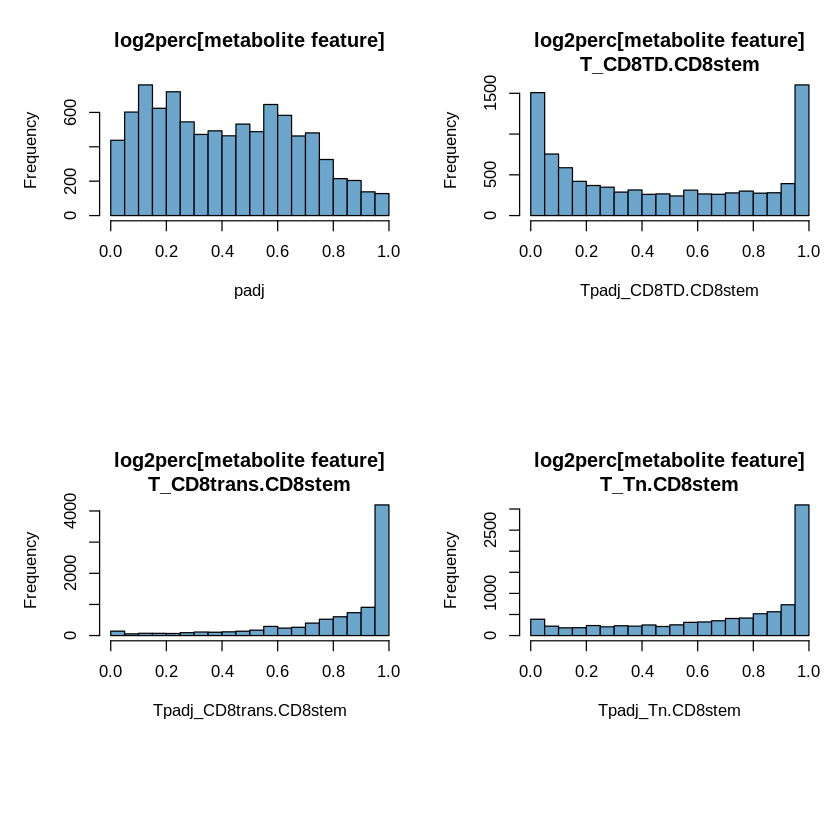

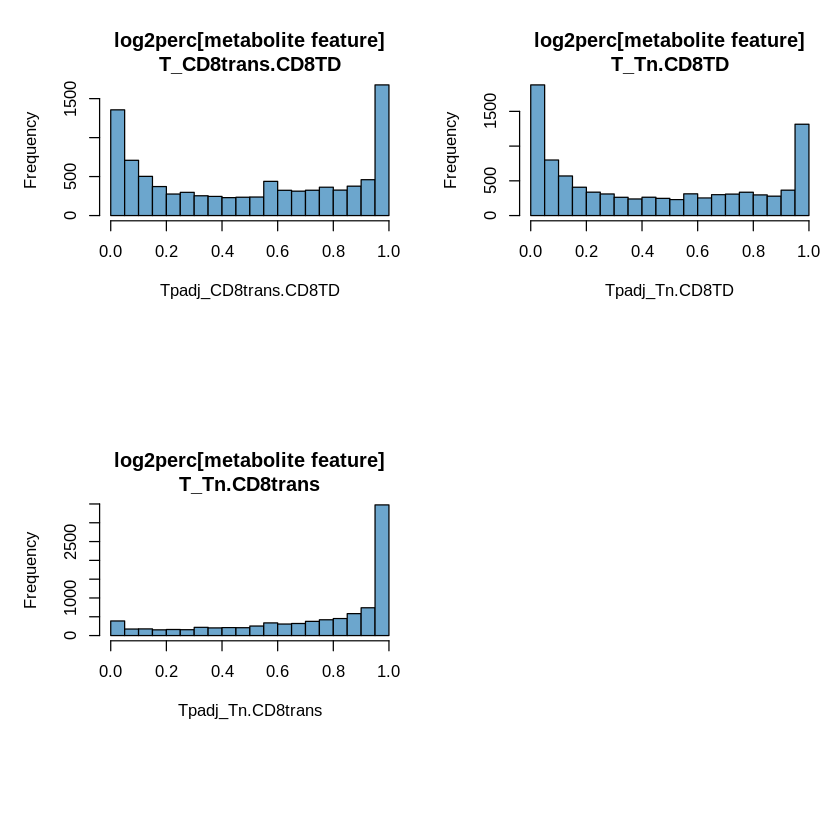

In [40]:
histogram_p(aov_tuk_df,'padj','\nlog2perc[metabolite feature]')

[1] "TFDR_CD8TD.CD8stem"    "TFDR_CD8trans.CD8stem" "TFDR_Tn.CD8stem"      
[4] "TFDR_CD8trans.CD8TD"   "TFDR_Tn.CD8TD"         "TFDR_Tn.CD8trans"     


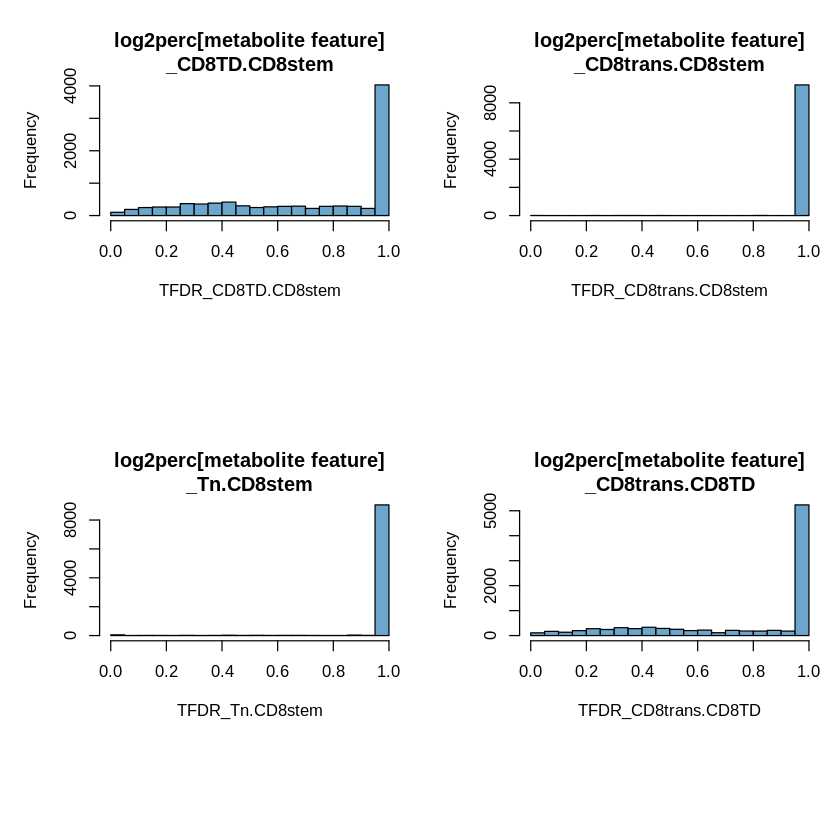

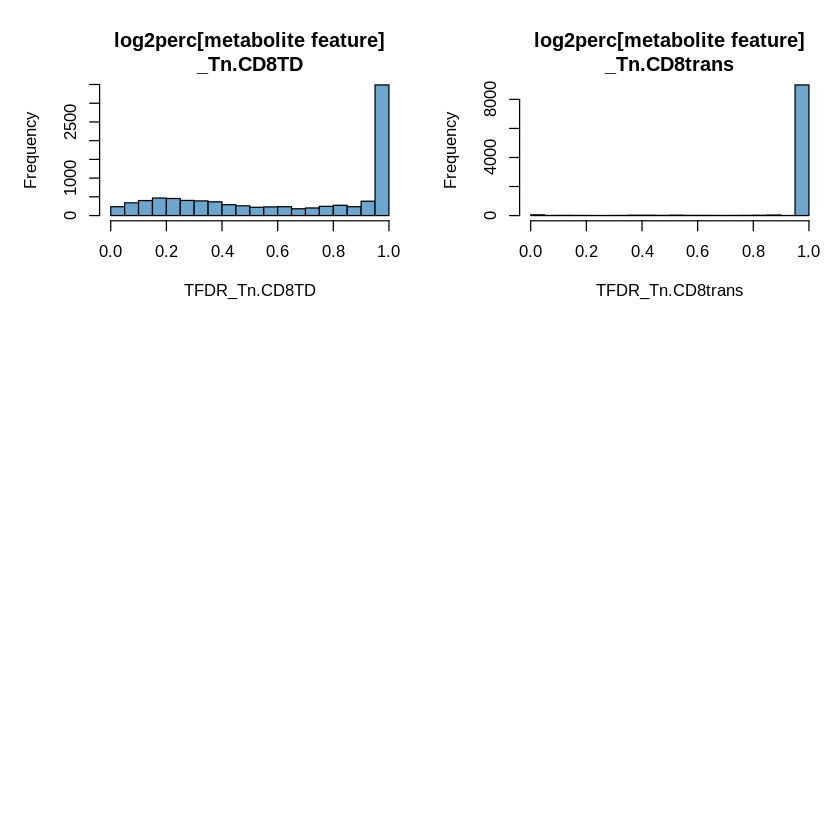

In [41]:
histogram_p(aov_tuk_df,'TFDR','\nlog2perc[metabolite feature]')

[1] "pval"


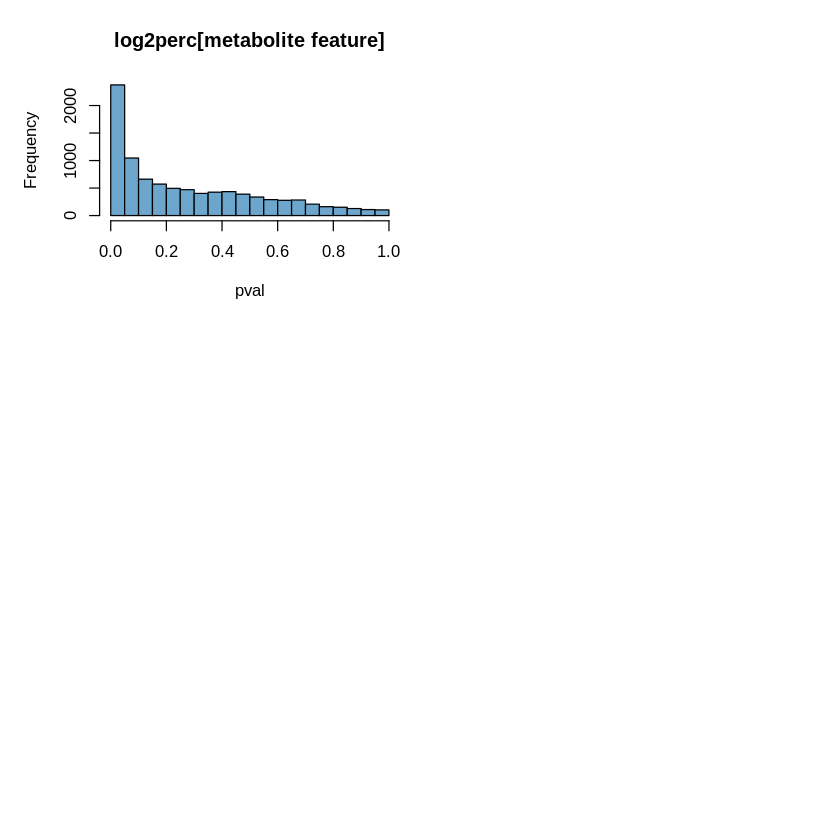

In [42]:
histogram_p(aov_tuk_df,'pval','\nlog2perc[metabolite feature]')

In [43]:
colnames(aov_tuk_df)

[1] "f_score"                "pval"                   "padj"                  
 [4] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
 [7] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"     
[10] "TFDR_CD8TD.CD8stem"     "TFDR_CD8trans.CD8stem"  "TFDR_Tn.CD8stem"       
[13] "TFDR_CD8trans.CD8TD"    "TFDR_Tn.CD8TD"          "TFDR_Tn.CD8trans"

In [44]:
sign_df = aov_tuk_df[(aov_tuk_df$padj < 0.05),]
sign_df[1:10,]

,f_score,pval,padj,Tpadj_CD8TD.CD8stem,Tpadj_CD8trans.CD8stem,Tpadj_Tn.CD8stem,Tpadj_CD8trans.CD8TD,Tpadj_Tn.CD8TD,Tpadj_Tn.CD8trans,TFDR_CD8TD.CD8stem,TFDR_CD8trans.CD8stem,TFDR_Tn.CD8stem,TFDR_CD8trans.CD8TD,TFDR_Tn.CD8TD,TFDR_Tn.CD8trans
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F10155,52.45095,1.142740e-03,0.035867404,0.0020740703,0.9986030548,0.8011277641,0.0019570902,0.0014735145,0.8677027133,0.08302030,1.0000000,1.00000000,0.08777213,0.05506991,1.00000000
F1016,172.16711,1.104491e-04,0.009252343,0.0001589773,0.5139222008,0.4727500141,0.0002048331,0.0002084150,0.9996592402,0.02390300,1.0000000,1.00000000,0.02727792,0.01850328,1.00000000
F10182,117.64308,2.346001e-04,0.015187098,1.0000000000,1.0000000000,0.0003680542,1.0000000000,0.0003680542,0.0003680542,1.00000000,1.0000000,0.06353706,1.00000000,0.02557014,0.06238184
F10221,188.47994,9.230095e-05,0.008285905,0.0001074902,0.0295111987,0.0121693051,0.0002243518,0.0003004154,0.5739273106,0.02044947,1.0000000,0.62105453,0.02866497,0.02276807,1.00000000
F10260,39.94516,1.935088e-03,0.045097231,0.0030169312,0.0030169312,0.0030169312,1.0000000000,1.0000000000,1.0000000000,0.09833508,0.7227732,0.29762975,1.00000000,1.00000000,1.00000000
F10261,57.62193,9.517722e-04,0.033127380,0.0014916335,0.0014916335,0.0014916335,1.0000000000,1.0000000000,1.0000000000,0.07475810,0.4738119,0.18790551,1.00000000,1.00000000,1.00000000
F10283,36.19940,2.338029e-03,0.049911082,0.0062724576,0.9999981672,0.0062724576,0.0062209477,1.0000000000,0.0062209477,0.13258923,1.0000000,0.43571249,0.14570773,1.00000000,0.42414249
F10284,47.22871,1.400461e-03,0.038523292,0.0030990618,0.7716247635,0.0030990618,0.0048098548,1.0000000000,0.0048098548,0.09961881,1.0000000,0.29782942,0.12921460,1.00000000,0.39035063
F10330,130.01159,1.925650e-04,0.013496923,0.0002669105,0.0002669105,0.0052860771,1.0000000000,0.0029321467,0.0029321467,0.03273868,0.2073450,0.41590944,1.00000000,0.07447953,0.29428090


In [45]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.05,])[1]

[1] 438

In [46]:
dim(aov_tuk_df[aov_tuk_df$padj < 0.1,])[1]

[1] 1040

In [47]:
dim(aov_tuk_df[aov_tuk_df$pval < 0.05,])[1] # check raw p value

[1] 2375

-------

----

# construct the final result tables

In [48]:
detect_boundary_index = function(feat_df = feat_df,
                                 Data_RegExpr = '\\_[0-9]+'
                                ) {
    # the output index is the last index for the metainfo
    first_index4data = grep(Data_RegExpr,colnames(feat_df))[1]
    # range = colnames(feat_df)[first_index4data - 1:first_index4data + 1]
    print(colnames(feat_df)[first_index4data-1])
    return(first_index4data-1)
}

In [49]:
wrap_res2ful <- function(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index) {
    metainfo_df = feat_df[,1:end_index]
    metainfo_df = merge_by_rowName(metainfo_df,aov_tuk_df) # use merge by rowname in utilis
    m_df = merge_by_rowName(metainfo_df,
                 feat_df[(end_index + 1):ncol(feat_df)]) # use merge by rowname in utilis
    return(m_df)
}
    

In [50]:
metainfo_end_index = detect_boundary_index(feat_df = feat_df, 
                                           Data_RegExpr = '\\_[0-9]+')
full_res_df <- wrap_res2ful(aov_tuk_df = aov_tuk_df,
                         feat_df = feat_df,
                         end_index = metainfo_end_index)

[1] "log2FC_CD8TDvsCD8trans"


In [51]:
dim(full_res_df)

[1] 9322   36

In [52]:
colnames(full_res_df)

[1] "gMean_Tn"                 "gMean_CD8stem"           
 [3] "gMean_CD8trans"           "gMean_CD8TD"             
 [5] "log2FC_CD8stemvsTn"       "log2FC_CD8transvsTn"     
 [7] "log2FC_CD8TDvsTn"         "log2FC_CD8transvsCD8stem"
 [9] "log2FC_CD8TDvsCD8stem"    "log2FC_CD8TDvsCD8trans"  
[11] "f_score"                  "pval"                    
[13] "padj"                     "Tpadj_CD8TD.CD8stem"     
[15] "Tpadj_CD8trans.CD8stem"   "Tpadj_Tn.CD8stem"        
[17] "Tpadj_CD8trans.CD8TD"     "Tpadj_Tn.CD8TD"          
[19] "Tpadj_Tn.CD8trans"        "TFDR_CD8TD.CD8stem"      
[21] "TFDR_CD8trans.CD8stem"    "TFDR_Tn.CD8stem"         
[23] "TFDR_CD8trans.CD8TD"      "TFDR_Tn.CD8TD"           
[25] "TFDR_Tn.CD8trans"         "CD8TD_750K_1"            
[27] "CD8TD_750K_2"             "CD8stem_250K_1"          
[29] "CD8stem_300K_2"           "CD8trans_250K_2"         
[31] "CD8trans_350K_1"          "Tn_250K_1"               
[33] "Tn_250K_2"                "pooled_1"                
[35] "pooled_2"                 "pooled_3"

## output

In [53]:
output_fdr = glue('../../output/{exp_label}_1wayANOVA/')
dir.create(output_fdr)

In [54]:
write.csv(full_res_df,
          file.path(output_fdr, 
                    glue('one_wayANOVA_{exp_label}_fullreport.csv')))

------

## Label PS

In [68]:
label_ps = TRUE

In [103]:
if(label_ps == TRUE) {
    PS_lab_df = read.csv("../../output/preproc_fultab_lab_targlist_79_rmTn750K/PSsel_FC_log2_hMinImp_TICn_groupFil0.3_RPneg_blkM_featab.csv")
    inner.m.ful.report.df = merge(PS_lab_df[,1:6],full_res_df,by.x = 'id_number',by.y = 0, all.x = TRUE)
    out.m.ful.report.df <- merge(PS_lab_df[,1:6], full_res_df, by.x = 'id_number', by.y = 0, all.y = TRUE)
    write.csv(inner.m.ful.report.df,file.path(output_fdr, 
                    glue('PS_sel_one_wayANOVA_{exp_label}_fullreport.csv')), row.names = FALSE)
    write.csv(out.m.ful.report.df,file.path(output_fdr, 
                    glue('PS_lab_one_wayANOVA_{exp_label}_fullreport.csv')),  row.names = FALSE)
    
}

------

------

In [55]:
col_stat_score = colnames(feat_df)[grep('log2FC',colnames(feat_df))]

In [56]:
col_stat_score

[1] "log2FC_CD8stemvsTn"       "log2FC_CD8transvsTn"     
[3] "log2FC_CD8TDvsTn"         "log2FC_CD8transvsCD8stem"
[5] "log2FC_CD8TDvsCD8stem"    "log2FC_CD8TDvsCD8trans"

In [57]:
col_padj_stat = colnames(aov_tuk_df)[grep('Tpadj',colnames(aov_tuk_df))]

In [58]:
col_padj_stat

[1] "Tpadj_CD8TD.CD8stem"    "Tpadj_CD8trans.CD8stem" "Tpadj_Tn.CD8stem"      
[4] "Tpadj_CD8trans.CD8TD"   "Tpadj_Tn.CD8TD"         "Tpadj_Tn.CD8trans"

In [59]:
grepl('(CD8TD\\.|vs)CD8stem',col_padj_stat)

[1]  TRUE FALSE FALSE FALSE FALSE FALSE

In [60]:
grepl('CD8stem(\\.|vs)Tn',col_stat_score)

[1]  TRUE FALSE FALSE FALSE FALSE FALSE

In [61]:
# because this table don't have mz, rtime; fetch those information
annot_df = read.csv("../../../asari-output-RPneg/output_asari_project_31312361//Feature_annotation.tsv",
                sep = '\t')[,1:3]

In [62]:
annot_full_res_df = merge(annot_df,full_res_df,by.x = 'X.peak.id_number', by.y = 0, how = 'right')

In [63]:
rownames(annot_full_res_df) = annot_full_res_df[['X.peak.id_number']]

In [64]:
contrast_regExprs = c('(CD8TD(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8TD)', # Sometimes log2FC AvsB but padj can be BvsA
                      '(CD8trans(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8trans)',
                      '(CD8stem(\\.|vs)Tn)|(Tn(\\.|vs)CD8stem)',
                      '(CD8trans(\\.|vs)CD8TD)|(CD8TD(\\.|vs)CD8trans)',
                      '(Tn(\\.|vs)CD8TD)|(CD8TD(\\.|vs)Tn)',
                      '(Tn(\\.|vs)CD8trans)|(CD8trans(\\.|vs)Tn)')

res2mcg_tukey <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # Use log2FC as stat and padj/TFDR from tukey test for p cutoff
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        print(regExpr)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        # print(grep(glue("{stat_label}\\_{regExpr}"),coln))
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        print(strsplit(stat_col,'_')[[1]])
        true_label = strsplit(stat_col,'_')[[1]][2]
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [65]:
res2mcg_tukey(full_res_df = annot_full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'TFDR', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

[1] "(CD8TD(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8TD)"
[1] "log2FC"         "CD8TDvsCD8stem"
[1] "(CD8trans(\\.|vs)CD8stem)|(CD8stem(\\.|vs)CD8trans)"
[1] "log2FC"            "CD8transvsCD8stem"
[1] "(CD8stem(\\.|vs)Tn)|(Tn(\\.|vs)CD8stem)"
[1] "log2FC"      "CD8stemvsTn"
[1] "(CD8trans(\\.|vs)CD8TD)|(CD8TD(\\.|vs)CD8trans)"
[1] "log2FC"          "CD8TDvsCD8trans"
[1] "(Tn(\\.|vs)CD8TD)|(CD8TD(\\.|vs)Tn)"
[1] "log2FC"    "CD8TDvsTn"
[1] "(Tn(\\.|vs)CD8trans)|(CD8trans(\\.|vs)Tn)"
[1] "log2FC"       "CD8transvsTn"


## 2-steps to control tukey stat


In [66]:
res2mcg_tukey_2steps <- function(full_res_df = full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj',
                         stat_label = 'log2FC',
                         output_fdr = output_fdr) {
    # With 2 steps, the data go after Tpadj, 
    # but turn to 1 if the feature didn't pass the 1-way ANOVA FDR
    # Use log2FC as stat and padj from tukey test for p cutoff
    
    for (regExpr in contrast_regExprs) {
        coln = colnames(full_res_df)
        padj_col = coln[grep(glue("{padj_label}\\_{regExpr}"),coln)]
        stat_col = coln[grep(glue("{stat_label}\\_{regExpr}"),coln)]
        mcg_df = full_res_df[c('mz','rtime',padj_col,stat_col,'padj')]
        mcg_df['id_number'] = rownames(full_res_df)
        
        true_label = strsplit(stat_col,'_')[[1]][2] # just quick way to get the contrast
        
        mcg_df[glue("org_{padj_col}")] = mcg_df[padj_col]
        mcg_df[mcg_df$padj > 0.05, padj_col] = 1
        
        write.table(mcg_df,
          file.path(output_fdr, 
                    glue('{true_label}_{exp_label}_{padj_label}_2steps_4mcg.txt')),
                    sep = '\t',
                    row.names = FALSE)

    }
        
}

In [67]:
res2mcg_tukey_2steps(full_res_df = annot_full_res_df,
                         contrast_regExprs = contrast_regExprs,
                         padj_label = 'Tpadj', # using tukey FDR instead
                         stat_label = 'log2FC',
                         output_fdr = output_fdr)

------

## Summary: normal one-way ANOVA
- with Tukey post-hoc test
- Run through all the contrast